### **Load Dan Menampilkan Data**

In [23]:
import pandas as pd

# Unggah file (di Colab: klik ikon folder > upload file)
train_df = pd.read_csv('train.txt', header=None)
val_df = pd.read_csv('val.txt', header=None)
test_df = pd.read_csv('test.txt', header=None)

# Menampilkan beberapa baris pertama dari masing-masing dataset
print("=== DATA TRAIN ===")
print(train_df.head(), "\n")

print("=== DATA VALIDASI ===")
print(val_df.head(), "\n")

print("=== DATA TEST ===")
print(test_df.head(), "\n")


=== DATA TRAIN ===
                                                   0
0                    i didnt feel humiliated;sadness
1  i can go from feeling so hopeless to so damned...
2  im grabbing a minute to post i feel greedy wro...
3  i am ever feeling nostalgic about the fireplac...
4                         i am feeling grouchy;anger 

=== DATA VALIDASI ===
                                                   0
0  im feeling quite sad and sorry for myself but ...
1  i feel like i am still looking at a blank canv...
2                i feel like a faithful servant;love
3            i am just feeling cranky and blue;anger
4  i can have for a treat or if i am feeling fest... 

=== DATA TEST ===
                                                   0
0  im feeling rather rotten so im not very ambiti...
1  im updating my blog because i feel shitty;sadness
2  i never make her separate from me because i do...
3  i left with my bouquet of red and yellow tulip...
4  i was feeling a little vain when 

### **Preprocessing Text**

In [24]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt

nltk.download('punkt')

# Fungsi padding
def padd(tokens, max_len=100):
    tokens = tokens[:max_len]
    while len(tokens) < max_len:
        tokens.append('<pad>')
    return tokens

# Fungsi preprocessing teks
def preprocess_text_column(df, text_col_name='text'):
    tokenized = [str(s).lower().split() for s in df[text_col_name]]
    return tokenized

# Fungsi untuk memuat data dari file .txt
def load_data_from_txt(path):
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    data = []
    for line in lines:
        try:
            text_and_label = line.strip().split(';')
            if len(text_and_label) == 2:
                full_text = text_and_label[0]
                label = text_and_label[1]
                text = ' '.join(full_text.split(' ')[1:])
                data.append((text, label))
        except:
            continue
    df = pd.DataFrame(data, columns=['text', 'emotion'])
    df.dropna(subset=['emotion'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Fungsi untuk menampilkan contoh sebelum dan sesudah preprocessing
def display_preprocessing_examples(df, tokens, title="Dataset"):
    print(f"\n===== {title.upper()} EXAMPLES =====")
    for i in range(min(2, len(df))):
        print(f"\nContoh ke-{i+1}:")
        print("Sebelum:", df.iloc[i]['text'])
        print("Sesudah:", tokens[i])

# Load dataset
train_df = load_data_from_txt('train.txt')
val_df = load_data_from_txt('val.txt')
test_df = load_data_from_txt('test.txt')

# Preprocessing
train_tokens = [padd(tokens) for tokens in preprocess_text_column(train_df)]
val_tokens = [padd(tokens) for tokens in preprocess_text_column(val_df)]
test_tokens = [padd(tokens) for tokens in preprocess_text_column(test_df)]

# Tampilkan contoh
display_preprocessing_examples(train_df, train_tokens, "Train")
display_preprocessing_examples(val_df, val_tokens, "Validation")
display_preprocessing_examples(test_df, test_tokens, "Test")



===== TRAIN EXAMPLES =====

Contoh ke-1:
Sebelum: didnt feel humiliated
Sesudah: ['didnt', 'feel', 'humiliated', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Contoh ke-2:

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### **Load Embedding GloVe dan Konversi ke Vektor**

In [25]:
# Load GloVe embeddings
embedding_index = {}
with open("glove.6B.50d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Fungsi konversi kalimat ke vektor
def vectorize(tokens_list, embedding_dim=50):
    vectorized = []
    for sentence in tokens_list:
        embedded_sentence = []
        for word in sentence:
            if word in embedding_index:
                embedded_sentence.append(embedding_index[word])
            else:
                embedded_sentence.append(np.zeros(embedding_dim))
        vectorized.append(embedded_sentence)
    return np.array(vectorized)

# Vektorisasi
X_train = vectorize(train_tokens)
X_val = vectorize(val_tokens)
X_test = vectorize(test_tokens)
print("Shape X_train:", X_train.shape)


Shape X_train: (16000, 100, 50)


#### **Encode Label**

In [27]:
# One-hot encoding untuk label
all_labels = pd.concat([train_df['emotion'], val_df['emotion'], test_df['emotion']])
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(np.array(all_labels).reshape(-1, 1))

Y_train = encoder.transform(np.array(train_df['emotion']).reshape(-1, 1))
Y_val = encoder.transform(np.array(val_df['emotion']).reshape(-1, 1))
Y_test = encoder.transform(np.array(test_df['emotion']).reshape(-1, 1))

print("Label Contoh (one-hot):", Y_train[0])
print("Jumlah kelas:", Y_train.shape[1])

Label Contoh (one-hot): [0. 0. 0. 0. 1. 0.]
Jumlah kelas: 6


#### **Model BiLSTM**

In [28]:
# Buat model BiLSTM yang ditingkatkan
def create_improved_bilstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))  # Kurangi dropout untuk mempertahankan lebih banyak informasi
    model.add(Bidirectional(LSTM(64)))  # Tambah layer LSTM kedua
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))  # Tambah dense layer
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = Adam(learning_rate=0.0005)  # Kurangi learning rate
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Buat dan latih model
model = create_improved_bilstm_model((100, 50), Y_train.shape[1])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 100, 256)       │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,974 (1.34 MB)

 Trainable params: 351,974 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

#### **Training**

In [29]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Latih model dengan lebih banyak epoch
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=50,
                    batch_size=128,
                    callbacks=[early_stopping])


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.3318 - loss: 1.6290 - val_accuracy: 0.4890 - val_loss: 1.3660
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4832 - loss: 1.3852 - val_accuracy: 0.5275 - val_loss: 1.2353
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5231 - loss: 1.2567 - val_accuracy: 0.5610 - val_loss: 1.1566
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5755 - loss: 1.1413 - val_accuracy: 0.6115 - val_loss: 1.0300
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6024 - loss: 1.0655 - val_accuracy: 0.6525 - val_loss: 0.9587
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6465 - loss: 0.9726 - val_accuracy: 0.6740 - val_loss: 0.8713
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6789 - loss: 0.8839 - val_accuracy: 0.7020 - val_loss: 0.8194
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6973 - loss: 0.8295 - val_accu

#### **Evaluasi**

In [30]:
loss, acc = model.evaluate(X_test, Y_test)
print("Akurasi Test:", acc)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8456 - loss: 0.4623
Akurasi Test: 0.8504999876022339


#### **Plot Akurasi dan Loss**

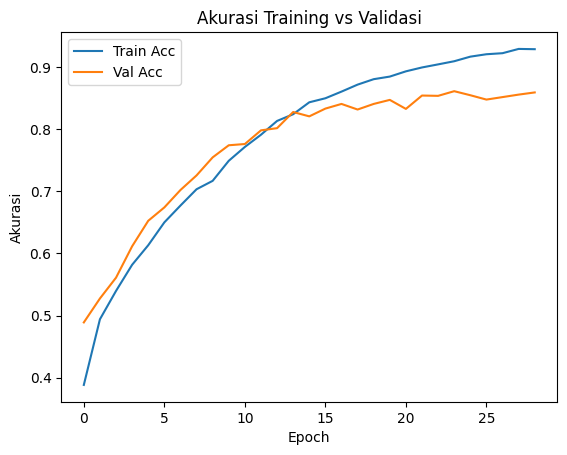

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()
plt.title("Akurasi Training vs Validasi")
plt.show()


#### **Tes Data Baru**

In [34]:
# Fungsi untuk memproses dan memprediksi data baru
def predict_new_data(text, encoder, embedding_index, model, max_len=100, embedding_dim=50):
    # Preprocess teks baru
    tokens = str(text).lower().split()
    tokens = padd(tokens, max_len)
    # Vektorisasi
    embedded_sentence = []
    for word in tokens:
        if word in embedding_index:
            embedded_sentence.append(embedding_index[word])
        else:
            embedded_sentence.append(np.zeros(embedding_dim))
    X_new = np.array([embedded_sentence])
    # Prediksi
    prediction = model.predict(X_new)
    predicted_label = encoder.inverse_transform(prediction)[0][0]
    return predicted_label

# Interaktif: Meminta input dari pengguna
print("\n===== PREDIKSI DATA BARU =====")
print("Masukkan teks untuk memprediksi emosi (ketik 'selesai' untuk berhenti):")
while True:
    user_input = input("Teks: ")
    if user_input.lower() == 'selesai':
        print("Prediksi selesai.")
        break
    if user_input.strip() == "":
        print("Teks tidak boleh kosong. Coba lagi.")
        continue
    predicted_emotion = predict_new_data(user_input, encoder, embedding_index, model)
    print(f"Emosi yang diprediksi: {predicted_emotion}\n")


===== PREDIKSI DATA BARU =====
Masukkan teks untuk memprediksi emosi (ketik 'selesai' untuk berhenti):
Teks: I feel so happy today because I got a promotion!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Emosi yang diprediksi: joy

Teks: This is the worst day ever, everything is going wrong.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Emosi yang diprediksi: anger

Teks: selesai
Prediksi selesai.
